### Michigan University Sentiment Classification Contest (from Kaggle)
https://www.kaggle.com/c/si650winter11

This contest was hosted by Michigan university for a course. The data set has senteces extracted from social media and then classified into positive or negative. **The training data contains 7086 sentences, already labeled with 1 (positive sentiment) or 0 (negative sentiment).** The data set also contains unlabled data but for this post, I will ONLY use labelled data.

I found this data set interesting for learning purpose.

I will divide the dataset into training and testing sets. The sentiment is sorted in the file so will shuffle the input data and then use first 5000 as training and rest as testing dataset.  

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from string import punctuation
from collections import Counter
%matplotlib inline

I have downloaded the Training data and stored the content in a file named as **michigan_sentiment.txt**.

## Step 1.  DataSet Preparation
Load the data and explore it.

In [2]:
sentiment_data = pd.read_csv('michigan_sentiment.txt', sep='\t') # read in a Pandas data frame
sentiment_data.columns =['Class', 'Data']

In [3]:
total_reviews = len(sentiment_data);
print("Total Review count {}".format(total_reviews))
print('Columns = {}'.format(sentiment_data.columns.values))
print('Dimension of sentiment_data is {}'.format(sentiment_data.shape))
print('Number of reviews ={}'.format(total_reviews))   # or sentiment_data.shape[0]
print('Dimension ={}'.format(sentiment_data.shape))
print('Sentiment Distribution ={} '.format(sentiment_data['Class'].value_counts()))
sentiment_data.head()
#sentiment_data.describe()

Total Review count 6917
Columns = ['Class' 'Data']
Dimension of sentiment_data is (6917, 2)
Number of reviews =6917
Dimension =(6917, 2)
Sentiment Distribution =1    3942
0    2975
Name: Class, dtype: int64 


,Class,Data
0,1,this was the first clive cussler i've ever rea...
1,1,i liked the Da Vinci Code a lot.
2,1,i liked the Da Vinci Code a lot.
3,1,I liked the Da Vinci Code but it ultimatly did...
4,1,that's not even an exaggeration ) and at midni...


## Step 2. Preprocessing

### Randomization/Shuffle Dataframe

The data is sorted; so we have positive reviews and then followed by all negative reviews. First of all we need to shuffle the dataset so that the modeling is proper. Also, we are using this labeled data for testing as well so we need to have good mix of positive and negative sentiment in each set. 

In [4]:
from sklearn.utils import shuffle

shuffled_sentiment_data = shuffle(sentiment_data)

### Split to reviews/input and labels/output data
The *Class* column has labels or output and the *Data* column has reviews or inputs in form of text

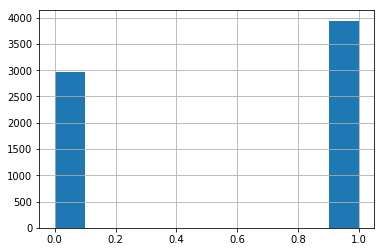

In [5]:
labels_series = shuffled_sentiment_data['Class']   # pandas
inputs_series = shuffled_sentiment_data['Data']

# Convert above pandas series into numpy array
labels = labels_series.values   
inputs = inputs_series.values
outputs = labels 

labels_series.hist()

### Clean Text

Remove special characters and also stop words.


In [6]:
import re
special_chars = re.compile("[^A-Za-z]+")   # Remove end of sentence as well

def cleanText(review):
    '''
    Remove punctuation, numbers and special characters.
    Also convert all chars to lower case
    '''
    review = review.lower() # convert to lower case
    return re.sub(special_chars, " ", review) # remove all non alphabetic chars with space

In [7]:
import nltk
from nltk.corpus import stopwords # Import the stop word list

def removeStopWords(review):
    '''
    Remove stop words from the reviews
    '''
    stops = set(stopwords.words("english"))  # set of stop words
    review = review.split()  
    words = [w for w in review if not w in stops]
    return( " ".join( words )) # joins the words array back to text

### Go through all text and clean them

In [8]:
cleaned_inputs = []

for val in inputs:
    cleaned = cleanText(val)
    without_stop_words = removeStopWords(cleaned)
    cleaned_inputs.append(without_stop_words)

In [9]:
print(len(cleaned_inputs))
print(len(inputs))

for i in range(5):
    print('BEFORE: {}'.format(inputs[i]))
    print('AFTER: {}'.format(cleaned_inputs[i]))
    print('---')
    
# print(cleaned_inputs[:10])

6917
6917
BEFORE: I wanted desperately to love'The Da Vinci Code as a film.
AFTER: wanted desperately love da vinci code film
---
BEFORE: I love The Da Vinci Code...
AFTER: love da vinci code
---
BEFORE: dudeee i LOVED brokeback mountain!!!!
AFTER: dudeee loved brokeback mountain
---
BEFORE: I want to be here because I love Harry Potter, and I really want a place where people take it serious, but it is still so much fun.
AFTER: want love harry potter really want place people take serious still much fun
---
BEFORE: da vinci code was an awesome movie...
AFTER: da vinci code awesome movie
---


### Creating Vocab
In ths step we are creating the vocabulary of all the reviews. 

In [10]:
all_words = []

for text in cleaned_inputs:
    for word in text.split():
        all_words.append(word)

In [11]:
unique_words = set(all_words)

print('Total words {}'.format(len(all_words)))
print('Unique words {}'.format(len(unique_words)))

Total words 46648
Unique words 1993


### Convert words to integers for the unique words

Create word to integer mapping (for all unique words).

In [12]:
vocab_to_int = {word: i for i, word in enumerate(unique_words, 1)}
vocab_to_int.items()

dict_items([('move', 1), ('w', 2), ('majorly', 3), ('grabs', 4), ('decaying', 5), ('quite', 6), ('offence', 7), ('meganpenworthy', 8), ('patirot', 9), ('oceanwalk', 10), ('strangely', 11), ('despised', 12), ('daniel', 13), ('shows', 14), ('jack', 15), ('hp', 16), ('tomkat', 17), ('jane', 18), ('lore', 19), ('knights', 20), ('afterschool', 21), ('pleased', 22), ('halle', 23), ('simple', 24), ('hips', 25), ('serious', 26), ('forever', 27), ('hugh', 28), ('whenever', 29), ('lot', 30), ('know', 31), ('photography', 32), ('prime', 33), ('mind', 34), ('yuck', 35), ('gonna', 36), ('thank', 37), ('tale', 38), ('bolsters', 39), ('maybe', 40), ('symantec', 41), ('harder', 42), ('wept', 43), ('given', 44), ('played', 45), ('anax', 46), ('images', 47), ('blashpemies', 48), ('mainstream', 49), ('anyways', 50), ('independant', 51), ('depressing', 52), ('irrespective', 53), ('clean', 54), ('queens', 55), ('land', 56), ('gladly', 57), ('able', 58), ('bit', 59), ('haircut', 60), ('lamest', 61), ('atroc

In [13]:
cleaned_inputs_words = []   ## array of review where each review again is an array

for review in cleaned_inputs:
    cleaned_inputs_words.append(review.split())

### Transform inputs into array of integers

Using vocab_to_int to transform each review to vector of numbers

In [14]:
cleaned_inputs_ints = []

for review in cleaned_inputs_words:
    cleaned_inputs_ints.append([vocab_to_int[word] for word in review])
   
reviews_lens = Counter([len(x) for x in cleaned_inputs_ints])
print('Zero-length {}'.format(reviews_lens[0]))
print("Max review length {}".format(max(reviews_lens)))

Zero-length 0
Max review length 487


### Creating word vectors

This step can be done as:
1. Define sequence length. (250 in this case)
2. Each review shorter then this sequence length will be padded (at the beginning) with zeros
3. Each review longer than the sequence length will be shortened.

In [15]:
seq_len = 250

# create matrix of size len(leaned_inputs_ints) X seq_len
features = np.zeros((len(cleaned_inputs_ints), seq_len), dtype=int)   

for i, review in enumerate(cleaned_inputs_ints):
    features[i, -len(review):] = np.array(review)[:seq_len]  # last 250 words

print(features[:10])

[[   0    0    0 ...,  392   66 1910]
 [   0    0    0 ...,  740  392   66]
 [   0    0    0 ..., 1974 1703   90]
 ..., 
 [   0    0    0 ...,  158 1703   90]
 [   0    0    0 ...,  588  940  329]
 [   0    0    0 ..., 1756 1874 1350]]


### Split into training and testing parts¶

In [16]:
X_train = features[:5000]
y_train = labels[:5000]

X_test = features[5000:]
y_test = labels[5000:]

print('X_train shape {}'.format(X_train.shape))
print('X_test shape {}'.format(X_test.shape))

X_trian shape (5000, 250)
X_test shape (1917, 250)


## Step 3. Modelling 

In [17]:
hidden_layer_size = 128  #512 how many nodes LSTM cells will have
number_of_layers = 1 # how many RNN layers the network will have
batch_size = 50 # how many reviews we feed at onces
learning_rate = 0.001 # learning rate
number_of_words = len(vocab_to_int) + 1 #how many unique words do we have in vocab (+1  is used for 0 - padding)
dropout_rate = 0.8 
embed_size = 300 #how long our word embedings will be
epochs = 5 # how many epochs do we use for training

In [18]:
tf.reset_default_graph() #Clean the graph

### Define placeholders¶

In [19]:
inputs = tf.placeholder(tf.int32, [None, None], name='inputs')
targets = tf.placeholder(tf.int32, [None, None], name='targets')

### Define embeding layer

In [20]:
word_embedings = tf.Variable(tf.random_uniform((number_of_words, embed_size), -1, 1))
embed = tf.nn.embedding_lookup(word_embedings, inputs)


### Define hidden layer and Dynamic RNN¶

In [21]:
hidden_layer = tf.contrib.rnn.BasicLSTMCell(hidden_layer_size)
hidden_layer = tf.contrib.rnn.DropoutWrapper(hidden_layer, dropout_rate)

cell = tf.contrib.rnn.MultiRNNCell([hidden_layer]*number_of_layers)
init_state = cell.zero_state(batch_size, tf.float32)

In [22]:
outputs, states = tf.nn.dynamic_rnn(cell, embed, initial_state=init_state)

### Get the prediction for each review
From the last step of our network we get output and use it as a prediction. Than we use that result and compare it with real sentiment for that review.

In [23]:
prediction = tf.layers.dense(outputs[:, -1], 1, activation=tf.sigmoid)
cost = tf.losses.mean_squared_error(targets, prediction)

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

### Define accuracy

In [24]:
currect_pred = tf.equal(tf.cast(tf.round(prediction), tf.int32), targets)
accuracy = tf.reduce_mean(tf.cast(currect_pred, tf.float32))

## Step 4. Training

In [25]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [26]:
for i in range(epochs):
    training_accurcy = []
    ii = 0
    epoch_loss = []
    while ii + batch_size <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size].reshape(-1, 1)
        
        a, o, _ = session.run([accuracy, cost, optimizer], feed_dict={inputs:X_batch, targets:y_batch})

        training_accurcy.append(a)
        epoch_loss.append(o)
        ii += batch_size
    print('Epoch: {}/{}'.format(i, epochs), ' | Current loss: {}'.format(np.mean(epoch_loss)),
          ' | Training accuracy: {:.4f}'.format(np.mean(training_accurcy)*100))

Epoch: 0/5  | Current loss: 0.04459916427731514  | Training accuracy: 94.4600
Epoch: 1/5  | Current loss: 0.004780552815645933  | Training accuracy: 99.4600
Epoch: 2/5  | Current loss: 0.002057114150375128  | Training accuracy: 99.7600
Epoch: 3/5  | Current loss: 0.001287223887629807  | Training accuracy: 99.8600
Epoch: 4/5  | Current loss: 0.0008348678820766509  | Training accuracy: 99.9200


## Step 5. Testing

In [27]:
test_accuracy = []

ii = 0
while ii + batch_size <= len(X_test):
    X_batch = X_test[ii:ii+batch_size]
    y_batch = y_test[ii:ii+batch_size].reshape(-1, 1)

    a = session.run([accuracy], feed_dict={inputs:X_batch, targets:y_batch})
    
    test_accuracy.append(a)
    ii += batch_size

In [28]:
print("Test accuracy is {:.4f}%".format(np.mean(test_accuracy)*100))

Test accuracy is 99.0526%


#### Happy ML!